In this project, I am going to predict categories of BBC new atricles in test data set.
Before getting to the prediction step, mutiple supervised models will be tested and we will find
which supervised model works the best for text classification.

Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss

Loading Data.
Data is from Kaggle, BBC News Archive. 
https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive?select=bbc-news-data.csv

In [2]:
#Loading the BBC news artile data
BBC_data = pd.read_csv('bbc-news-data.csv', sep='\t')
BBC_data.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


There are 4 columns in BBC_data.
I do not need filename and title for the prediction later, so I am going to drop those 2 columns.

In [3]:
#Dropping some unnecessary columns
BBC_data = BBC_data.drop(columns=['title', 'filename'])
BBC_data.head()

,category,content
0,business,Quarterly profits at US media giant TimeWarne...
1,business,The dollar has hit its highest level against ...
2,business,The owners of embattled Russian oil giant Yuk...
3,business,British Airways has blamed high fuel prices f...
4,business,Shares in UK drinks and food firm Allied Dome...


I am going add a new column named 'ArticleID' which contains indices of each article.
Then, rename the columns and recorder them.

In [4]:
#Creating a new column called 'ArticleID'
BBC_data['ArticleID'] = BBC_data.index

#Renaming some original columns
BBC_data = BBC_data.rename(columns={'content':'Text', 'category':'Category'})

#Reordering the columns
BBC_data = BBC_data[['ArticleID', 'Text', 'Category']]
BBC_data.head()

,ArticleID,Text,Category
0,0,Quarterly profits at US media giant TimeWarne...,business
1,1,The dollar has hit its highest level against ...,business
2,2,The owners of embattled Russian oil giant Yuk...,business
3,3,British Airways has blamed high fuel prices f...,business
4,4,Shares in UK drinks and food firm Allied Dome...,business


BBC_data needs to be split into train and test for the supervised model training and predicting.
train: 80% and test: 20%.
After spliitng the data, 'Category' column of test data will be dropped because the purpose of this
project is to predict the cateogry of test data.

In [6]:
#Splitting the data: train & test data sets
BBC_train, BBC_test = train_test_split(BBC_data, test_size=0.2, random_state=42)

#Resetting indice of train_data
BBC_train.reset_index(drop=True, inplace=True)

#Resetting indice of test_data
BBC_test.reset_index(drop=True, inplace=True)

print(BBC_train.head())
print(BBC_test.head())

   ArticleID                                               Text       Category
0       1490   Ashley Cole has refused to blame Robin van Pe...          sport
1       2001   Sony PlayStation 2's slimmer shape has proved...           tech
2       1572   Newcastle have fined their Welsh striker Crai...          sport
3       1840   Re-using old mobile phones is not just good f...           tech
4        610   International films will be given the same pr...  entertainment
   ArticleID                                               Text  Category
0        414   UK house prices dipped slightly in November, ...  business
1        420   The London Stock Exchange (LSE) is planning t...  business
2       1644   Number eight Imanol Harinordoquy has been dro...     sport
3        416   Shares in UK banking group Barclays have rise...  business
4       1232   Labour and the Conservatives are still teleph...  politics


In [7]:
#Learning the basic information of the data sets
print("The shape of training data: ", BBC_train.shape)
print("The shape of test data:", BBC_test.shape)
print("--------------------------------------------------------")

print("Training Data")
print(BBC_train.describe())
print("Test Data")
print(BBC_test.describe())
print("--------------------------------------------------------")

print("Training Data")
print(BBC_train.info())
print("--------------------------------------------------------")
print("Test Data")
print(BBC_test.info())


The shape of training data:  (1780, 3)
The shape of test data: (445, 3)
--------------------------------------------------------
Training Data
         ArticleID
count  1780.000000
mean   1117.740449
std     640.108315
min       0.000000
25%     574.750000
50%    1123.500000
75%    1673.250000
max    2224.000000
Test Data
         ArticleID
count   445.000000
mean   1089.038202
std     651.937259
min      13.000000
25%     494.000000
50%    1057.000000
75%    1652.000000
max    2222.000000
--------------------------------------------------------
Training Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleID  1780 non-null   int64 
 1   Text       1780 non-null   object
 2   Category   1780 non-null   object
dtypes: int64(1), object(2)
memory usage: 41.8+ KB
None
--------------------------------------------------------
Test Data
<class 'pa

It looks like there is no NULL values in both of the data sets.
The training data set has additional column called "Category" that test data set
does not have. We are going to predict the category for the test data set.

Exploratoy Data Analysis

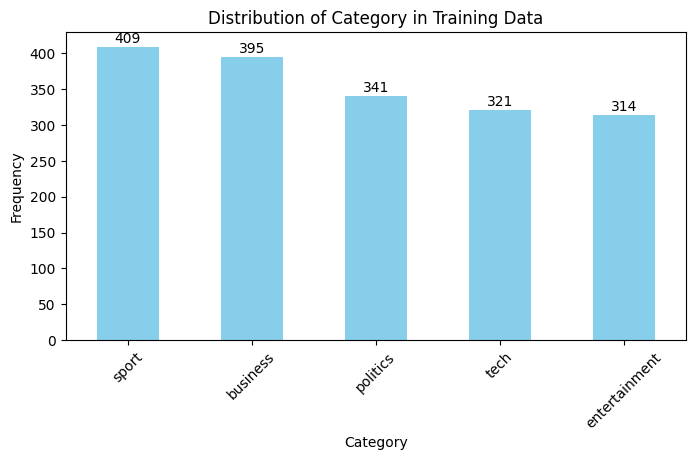

In [8]:
#Distribution of article categories (Histogram)
BBC_train_cat = BBC_train['Category'].value_counts()

plt.figure(figsize=(8,4))
plot1 =BBC_train_cat.plot(kind='bar', color='skyblue')
for p in plot1.patches:
    plot1.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', xytext=(0, 3), textcoords='offset points')
plt.title("Distribution of Category in Training Data")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


It looks like categories are well balanced so there would be no problem to train a model.
Let's check if there any duplicate 'Text' in the training data set.

In [9]:
duplicate_text = BBC_train[BBC_train['Text'].duplicated()]
duplicate_text_count = duplicate_text.shape[0]
print("There are", duplicate_text_count, "duplicate texts.")

There are 84 duplicate texts.


In [10]:
#Among the duplicates, what if there are some 'Text's assigned to different categories?
duplicate_text_whole = BBC_train[BBC_train['Text'].duplicated(keep=False)]
duplicate_count_by_category = duplicate_text_whole['Category'].value_counts()
print(duplicate_count_by_category)

Category
tech             88
politics         24
sport            24
entertainment    18
business         14
Name: count, dtype: int64


The even numbers for each category confirms that there is no duplicate texts assigned
to different categories. This is great! Now, we can remove the duplicates.

In [11]:
#Removing the duplicates.
BBC_train_cleaned = BBC_train.drop_duplicates(subset='Text', keep='first')
BBC_train_cleaned.shape

(1696, 3)

It looks like the 84 duplicates had been dropped properly. The original row count was 1780, 
but now it's 1696. 

Now, it's time to clean up the text.

In [12]:
#Here is one of the texts.
print(BBC_train_cleaned.Text[0])

 Ashley Cole has refused to blame Robin van Persie for leaving Arsenal with no fully-fit strikers for the FA Cup fifth round replay at Sheffield United.  Van Persie is suspended alongside Dennis Bergkamp and Jose Antonio Reyes after being sent off at Southampton when Arsenal had a numerical advantage. Thierry Henry is ruled out with an Achilles tendon injury but Cole said: "No-one is putting the blame on Robin. "It's just something that happens on the spur of the moment." Cole added: "I've done it before and I hope they didn't blame me for anything. "Of course he'll learn. I've been sent off a couple of times now and it's just one of those things when you go a bit crazy for one or two seconds. Freddie Ljungberg is likely to be used in an emergency striking role and will be partnered by either Arturo Lupoli, Quincy Owusu-Abeyie or Jeremie Aliadiere. Gunners boss Arsene Wenger said: "Freddie is an option but we need a second striker. "I have to decide whether it will be Aliadiere, Quincy

In [13]:
#Clean up the text by removing all the punctuations, numbers, unnecessary words and
#extra spaces.

def clean_up_text(data, col):
    data.loc[:, col]= data[col].apply(lambda item: re.sub(r'[^\w\s]+', ' ',item))
    data.loc[:, col]= data[col].apply(lambda item: re.sub(r'[0-9]+', ' ',item))
    stop_words = ['I', "the", "and", "a", "an", "to", "at"]
    stop_words_pattern = r'\b(' + '|'.join(stop_words) + r')\b'
    data.loc[:, col]= data[col].apply(lambda item: re.sub(stop_words_pattern, ' ',item))
    data.loc[:, col] = data[col].apply(lambda item: re.sub(' +', ' ',item))
                                        
    return data

In [14]:
#Applying the clean_up_text function
clean_up_text(BBC_train_cleaned, 'Text')
print(BBC_train_cleaned.Text[0])

 Ashley Cole has refused blame Robin van Persie for leaving Arsenal with no fully fit strikers for FA Cup fifth round replay Sheffield United Van Persie is suspended alongside Dennis Bergkamp Jose Antonio Reyes after being sent off Southampton when Arsenal had numerical advantage Thierry Henry is ruled out with Achilles tendon injury but Cole said No one is putting blame on Robin It s just something that happens on spur of moment Cole added ve done it before hope they didn t blame me for anything Of course he ll learn ve been sent off couple of times now it s just one of those things when you go bit crazy for one or two seconds Freddie Ljungberg is likely be used in emergency striking role will be partnered by either Arturo Lupoli Quincy Owusu Abeyie or Jeremie Aliadiere Gunners boss Arsene Wenger said Freddie is option but we need second striker have decide whether it will be Aliadiere Quincy or Lupoli who will start with him up front Those three will be involved Arsenal are also with

In [15]:
#Total word count per text
BBC_train_cleaned.loc[:, 'word_count'] = BBC_train_cleaned['Text'].apply(lambda x: len(x.split()))
BBC_train_cleaned.head(10)

/var/folders/8p/2flq48dn0nq0x83wdjqtjlrm0000gn/T/ipykernel_39046/46024777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BBC_train_cleaned.loc[:, 'word_count'] = BBC_train_cleaned['Text'].apply(lambda x: len(x.split()))


,ArticleID,Text,Category,word_count
0,1490,Ashley Cole has refused blame Robin van Persi...,sport,218
1,2001,Sony PlayStation s slimmer shape has proved p...,tech,392
2,1572,Newcastle have fined their Welsh striker Crai...,sport,418
3,1840,Re using old mobile phones is not just good f...,tech,455
4,610,International films will be given same promin...,entertainment,269
5,23,The gap between US exports imports hit all ti...,business,269
6,1904,Internet search engine users are odd mix of n...,tech,431
7,427,The Karachi Stock Exchange KSE has recorded i...,business,473
8,861,At Bafta film awards on Saturday night there ...,entertainment,435
9,988,Tony Blair should set out proper exit strateg...,politics,223


[Text(0.5, 1.0, 'Number of words per article by category')]

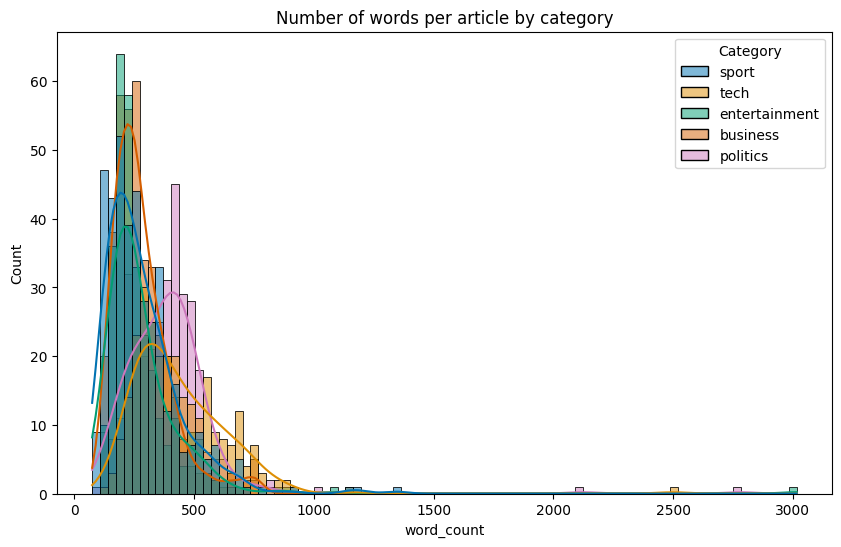

In [16]:
#Histrogram to see the word count distribution.
plt.figure(figsize=(10, 6))
sns.histplot(data = BBC_train_cleaned, x = 'word_count', palette = 'colorblind', kde=True,
    hue = 'Category').set(title = 'Number of words per article by category')

It looks like most of the texts are less than 600 words.

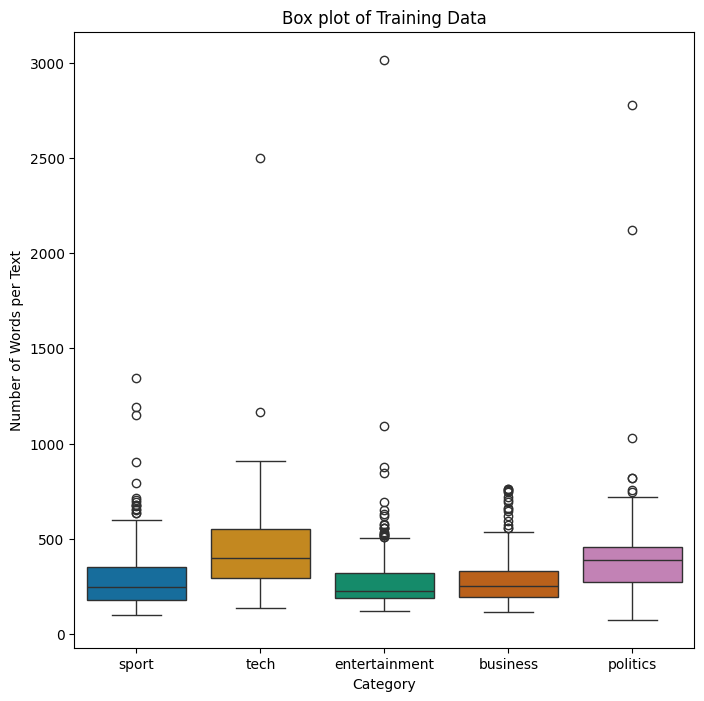

In [17]:
#Boxplots of word counts by categories.
plt.figure(figsize=(8,8))
sns.boxplot(data=BBC_train_cleaned, x='Category', y='word_count', hue='Category', palette='colorblind')
plt.ylabel('Number of Words per Text')
plt.title('Box plot of Training Data')
plt.show()

I see 1 outlier at tech, 1 outlier at entertainment and 2 outliers at politics. These outliers might cause
overfitting later on, so I am going to remove those outliers.

In [18]:
#Sorting the outliers
tech_sorted = BBC_train_cleaned[BBC_train_cleaned['Category'] == 'tech'].sort_values(by='word_count', ascending=False)
outliers_tech = tech_sorted[:1]
enter_sorted = BBC_train_cleaned[BBC_train_cleaned['Category'] == 'entertainment'].sort_values(by='word_count', ascending=False)
outliers_enter = enter_sorted[:1]
politics_sorted = BBC_train_cleaned[BBC_train_cleaned['Category'] == 'politics'].sort_values(by='word_count', ascending=False)
outliers_politics = politics_sorted[:2]

outlier_indices = outliers_enter.index.tolist() + outliers_tech.index.tolist() + outliers_politics.index.tolist()
#print(outlier_indices)
BBC_train_cleaned = BBC_train_cleaned.drop(outlier_indices)
BBC_train_cleaned.shape

(1692, 4)

It looks like 4 outliers has been removed properly.

Finally, let's build supervised models to predict the category for test data set.
First, I am choosing logistic regression model. This model estimates probability
that a given input belongs to a particular category. 
Logistic regression can't use categorical values so the TF-IDF vectorized
numbers can be used.

In [19]:
#Split the training data set into training and validation sets (80:20)
X = BBC_train_cleaned['Text']
y = BBC_train_cleaned['Category']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
#Building Logistic Regression Model
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_lr= tfidf_vectorizer.fit_transform(X_train)
lr_model = OneVsRestClassifier(LogisticRegression())
lr_model.fit(X_train_lr, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [21]:
#Logictic Regression with the validation data set
X_val_lr= tfidf_vectorizer.transform(X_val)
y_pred_val = lr_model.predict(X_val_lr)

#Accuracy
val_accuracy = accuracy_score(y_val, y_pred_val)

The logistic regression model had been trained and predicted the categories for the validation data set.

Next supervised model is Support Vector Machine (SVM).
SVM is a powerful classification technique that works well for text data.

In [22]:
#Building SVM
svm_model = make_pipeline(TfidfVectorizer(), SVC(kernel='linear', probability=True))
svm_model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('svc', SVC(kernel='linear', probability=True))])

In [23]:
#SVM with the validation data set
y_pred_val_svm = svm_model.predict(X_val)

#Accuracy
val_accuracy_svm = accuracy_score(y_val, y_pred_val_svm)

Last supervised model is Naive Bayes model. This model a new supervised model which was not covered
in the class.
Naive Bayes model is particularly effective for text classification especially with
TF-IDF representations.

In [24]:
#Building Naive Bayes
nb_model = make_pipeline(TfidfVectorizer(max_features=1000), MultinomialNB())
nb_model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=1000)),
                ('multinomialnb', MultinomialNB())])

In [25]:
#Naive Bayes with the validation data set
y_pred_val_nb = nb_model.predict(X_val)

#Accuracy
val_accuracy_nb = accuracy_score(y_val, y_pred_val_nb)

In [26]:
#Comparing Accuracy Scores
print("Accuracy for Logistic Regression: ", val_accuracy)
print("Accuracy for SVM: ", val_accuracy_svm)
print("Accuracy for Naive Bayes: ", val_accuracy_nb)

Accuracy for Logistic Regression:  0.967551622418879
Accuracy for SVM:  0.9852507374631269
Accuracy for Naive Bayes:  0.9646017699115044


We just looked at 3 different supervised model: logistic regression, support vectore machine
and naive bayes.
The accuracy scores are 0.97, 0.99 and 0.96 respectively.

It seems like SVM performs the best at predicting the categories of the news articles.
Accuracy score was chosen to be one of the evaluating metrics because the balance between
categories was good.

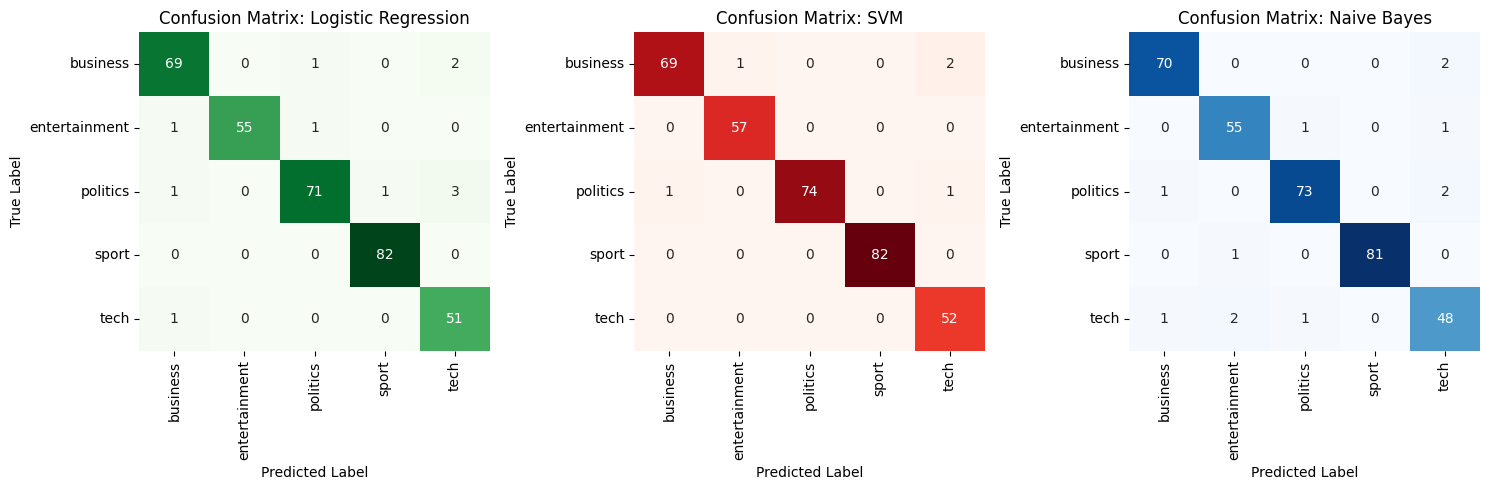

In [27]:
#Confusion Matrix
fig, axes = plt.subplots(1,3, figsize=(15,5))

cm_lr = confusion_matrix(y_val, y_pred_val, labels=lr_model.classes_)
cm_lr_df = pd.DataFrame(cm_lr, index=lr_model.classes_, columns=lr_model.classes_)
cm_svm = confusion_matrix(y_val, y_pred_val_svm, labels=svm_model.classes_)
cm_svm_df = pd.DataFrame(cm_svm, index=svm_model.classes_, columns=svm_model.classes_)
cm_nb = confusion_matrix(y_val, y_pred_val_nb, labels=nb_model.classes_)
cm_nb_df = pd.DataFrame(cm_nb, index=nb_model.classes_, columns=nb_model.classes_)

sns.heatmap(cm_lr_df, annot=True, ax=axes[0], fmt='d', cmap='Greens', cbar=False)
axes[0].set_title('Confusion Matrix: Logistic Regression')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_svm_df, annot=True, fmt='d', ax=axes[1], cmap='Reds', cbar=False)
axes[1].set_title('Confusion Matrix: SVM')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

sns.heatmap(cm_nb_df, annot=True, fmt='d', ax=axes[2], cmap='Blues', cbar=False)
axes[2].set_title('Confusion Matrix: Naive Bayes')
axes[2].set_ylabel('True Label')
axes[2].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

Here are the confusion matrices.

If you compare the values between models, the SVM's diagonal values are higher than other two models.

Of course, this result matches the restul of accuracy scores since the accuracy score calculation uses
the values within the confusion matrices.

I just wanted to visualize the values that were used for the accuracy scores.

---------------------------------------------------------------------------------------------------------
Here is Log-Loss evaluation method.

Log-Loss method focuses on the quality of the predicted probabilities.
On the other hand, accuracy score measures the proportion of correctly predicted instances
out of the total instances.
Log-Loss is common evaluating method for classification tasks.

In [28]:
#Log Loss
y_probs_lr = lr_model.predict_proba(X_val_lr)
loss_lr = log_loss(y_val, y_probs_lr)

y_probs_svm = svm_model.predict_proba(X_val)
loss_svm = log_loss(y_val, y_probs_svm)

y_probs_nb = nb_model.predict_proba(X_val)
loss_nb = log_loss(y_val, y_probs_nb)

print("Log Loss of Logistic Regression: ", loss_lr)
print("Log Loss of SVM: ", loss_svm)
print("Log Loss of Naive Bayes: ", loss_nb)

Log Loss of Logistic Regression:  0.39048424582539565
Log Loss of SVM:  0.06643121222096468
Log Loss of Naive Bayes:  0.23638463505557317


Lower Log-Loss value indicates better performance because as predictions deviate
from the true labels, the Log-Loss value increase.

The result of Log-Loss is SVM performs the best, then Naive Bayes and then Logistic Regression model.

It is slightly different from the result of accuracy scores: SVM > Logisic Regression > Naive Bayes.
Accruracy score and Log-Loss, both confirmed that SVM performs better than the other 2 models.

Finally, let's predict the categories of test data articles using SVM model.

In [31]:
#Predicting test data categories using SVM
X_test_svm = tfidf_vectorizer.transform(BBC_train['Text'])
y_pred_test = lr_model.predict(X_test_svm)
prediction_test = BBC_train.copy()
prediction_test['Predicted Category'] = y_pred_test
prediction_test

,ArticleID,Text,Category,Predicted Category
0,1490,Ashley Cole has refused to blame Robin van Pe...,sport,sport
1,2001,Sony PlayStation 2's slimmer shape has proved...,tech,tech
2,1572,Newcastle have fined their Welsh striker Crai...,sport,sport
3,1840,Re-using old mobile phones is not just good f...,tech,tech
4,610,International films will be given the same pr...,entertainment,entertainment
...,...,...,...,...
1775,1638,England captain Jason Robinson has rubbished ...,sport,sport
1776,1095,Middlesbrough mayor Ray Mallon has been draft...,politics,politics
1777,1130,The Lib Dems have appointed a senior figure f...,politics,politics
1778,1294,Sacked MP Howard Flight's local Conservative ...,politics,politics


If you compare the predicted categories and the original categories above, they match perfectly.

-----------------------------------------------------------------------------------------------------------------
Discussion:

In this project, multiple supervised models were implemented to predict the categories of BBC new articles,
fosucing on utilizing text data effectively. Logistic Regreesion, Suuport Vectore Machine(SVM) and Naive Bayes were
used. Accuracy score and log-loss evalution metrics were used for assessing the performances of the models.

Accuracy scores was chosen since the balance between categories was pretty good, and Log-loss was employed as another
evaluating method because it insights into the proability estimates produced by the a model while the accuracy score
focuses only on the proportion of correctly predicted incidents.

The result of accuracy score was SVM(0.99) > Logistic Regression(0.97) > Naive Bayes(0.96).
However, the result of Log-loss was SVM(0.07) > Naive Bayes(0.24) > Logistic Regression(0.39).
Hihger accuracy score is better but lower Log-loss is better.

After evaluating the models, I found that the SVM outperformed the others based on both metrics.
The SVM exhibited a higher accuracy score and lower log-loss value, indicating that it not only correctly
classified a greater number of articles but also produced more reliable probability estimates for each category.

The use of the TfidfVectorizer was particularly significant in transforming the text data into a format suitable for model training. This was my first experience using a vectorizer, and it proved essential for capturing the important features of the text, such as term frequency and inverse document frequency. The effectiveness of the SVM model in this context suggests that incorporating advanced text representation techniques can significantly enhance classification performance.

-----------------------------------------------------------------------------------------------------------------
Conclusion:

In conclusion, this project successfully demonstrated the ability to classify BBC news articles into their respective categories using machine learning techniques. The evaluation of models through accuracy scores and log-loss provided a robust framework for understanding model performances. Ultimately, the SVM model was the most effective, proving its capability in handling text classification tasks.

Moving forward, future work could involve exploring additional text preprocessing techniques, experimenting with hyperparameter tuning for the SVM model, or even investigating ensemble methods to further improve classification accuracy. Overall, this project has provided valuable insights into the complexities of text classification and the importance of choosing the right metrics for model evaluation.




-----------------------------------------------------------------------------------------------------------------
References:

1)Gultekin, H. n.d. BBC News Archive. https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive?select=bbc-news-data.csv.

2)Gusain, Anurag. 2020. "TF-IDF Vectorizer Explained." Medium. https://medium.com/@gusainanurag58/tf-idf-vectorizer-explained-373b3f07d23b#:~:text=The%20Term%20Frequency%2DInverse%20Document%20Frequency%20(TF%2DIDF),information%20retrieval%2C%20and%20topic%20modeling.

3)Spot Intelligence. 2023. "Logistic Regression for Text Classification in Python." Spot Intelligence. https://spotintelligence.com/2023/02/22/logistic-regression-text-classification-python/#:~:text=Once%20the%20model%20is%20trained,complex%20models%20in%20ensemble%20approaches.

4)Shandeep. 2021. "CountVectorizer vs TFIDFVectorizer." Medium. https://medium.com/@shandeep92/countvectorizer-vs-tfidfvectorizer-cf62d0a54fa4.

5)"Log Loss." Accessed October 7, 2024. https://www.activeloop.ai/resources/glossary/log-loss/#:~:text=Log%2DLoss%20is%20a%20widely,object%20based%20on%20its%20features.